# Rolling Regression

Rolling OLS applies OLS across a fixed windows of observations and then rolls 
(moves or slides) the window across the data set. They key parameter is `window` 
which determines the number of observations used in each OLS regression. By 
default, `RollingOLS` drops missing values in the window and so will estimate 
the model using the available data points.

Estimated values are aligned so that models estimated using data points 
$i+1, i+2, ... i+window$ are stored in location $i+window$. 

Start by importing the modules that are used in this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

seaborn.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

`pandas-datareader` is used to download data from
[Ken French's website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). 
The two data sets downloaded are the 3 Fama-French factors and the 10 industry portfolios. 
Data is available from 1926. 

The data are monthly returns for the factors or industry portfolios.

In [2]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
factors.head()

/tmp/ipykernel_5040/1924419770.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
/tmp/ipykernel_5040/1924419770.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


In [3]:
industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
industries.head()

/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]


/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_5040/268191425.py:1: F

/tmp/ipykernel_5040/268191425.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,1.45,15.55,4.69,-1.18,2.90,0.83,0.11,1.77,7.04,2.13
1926-08,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.35
1926-09,1.14,4.80,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.84
1926-11,5.20,-0.19,4.10,0.01,4.71,1.63,6.43,5.42,3.71,2.11


The first model estimated is a rolling version of the CAPM that regresses
the excess return of Technology sector firms on the excess return of the market.

The window is 60 months, and so results are available after the first 60 (`window`) 
months. The first 59 (`window - 1`) estimates are all `nan` filled.

In [4]:
endog = industries.HiTec - factors.RF.values
exog = sm.add_constant(factors["Mkt-RF"])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)
params.head()

,const,Mkt-RF
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN


In [5]:
params.iloc[57:62]

,const,Mkt-RF
58,NaN,NaN
59,NaN,NaN
60,0.876155,1.399240
61,0.879936,1.406578
62,0.953169,1.408826


In [6]:
params.tail()

,const,Mkt-RF
1176,0.610923,1.090145
1177,0.517339,1.089693
1178,0.503159,1.088327
1179,0.521466,1.088530
1180,0.514567,1.088413


We next plot the market loading along with a 95% point-wise confidence interval.
The `alpha=False` omits the constant column, if present.  

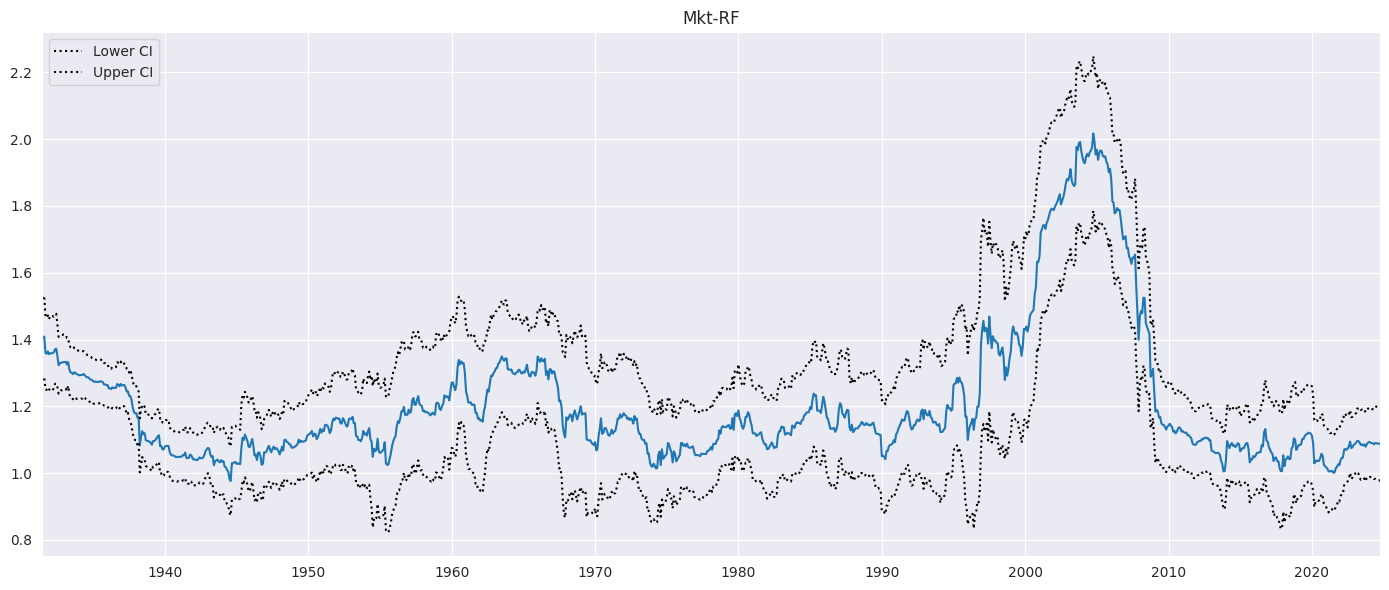

In [7]:
fig = rres.plot_recursive_coefficient(variables=["Mkt-RF"], figsize=(14, 6))

Next, the model is expanded to include all three factors, the excess market, the size factor
and the value factor. 

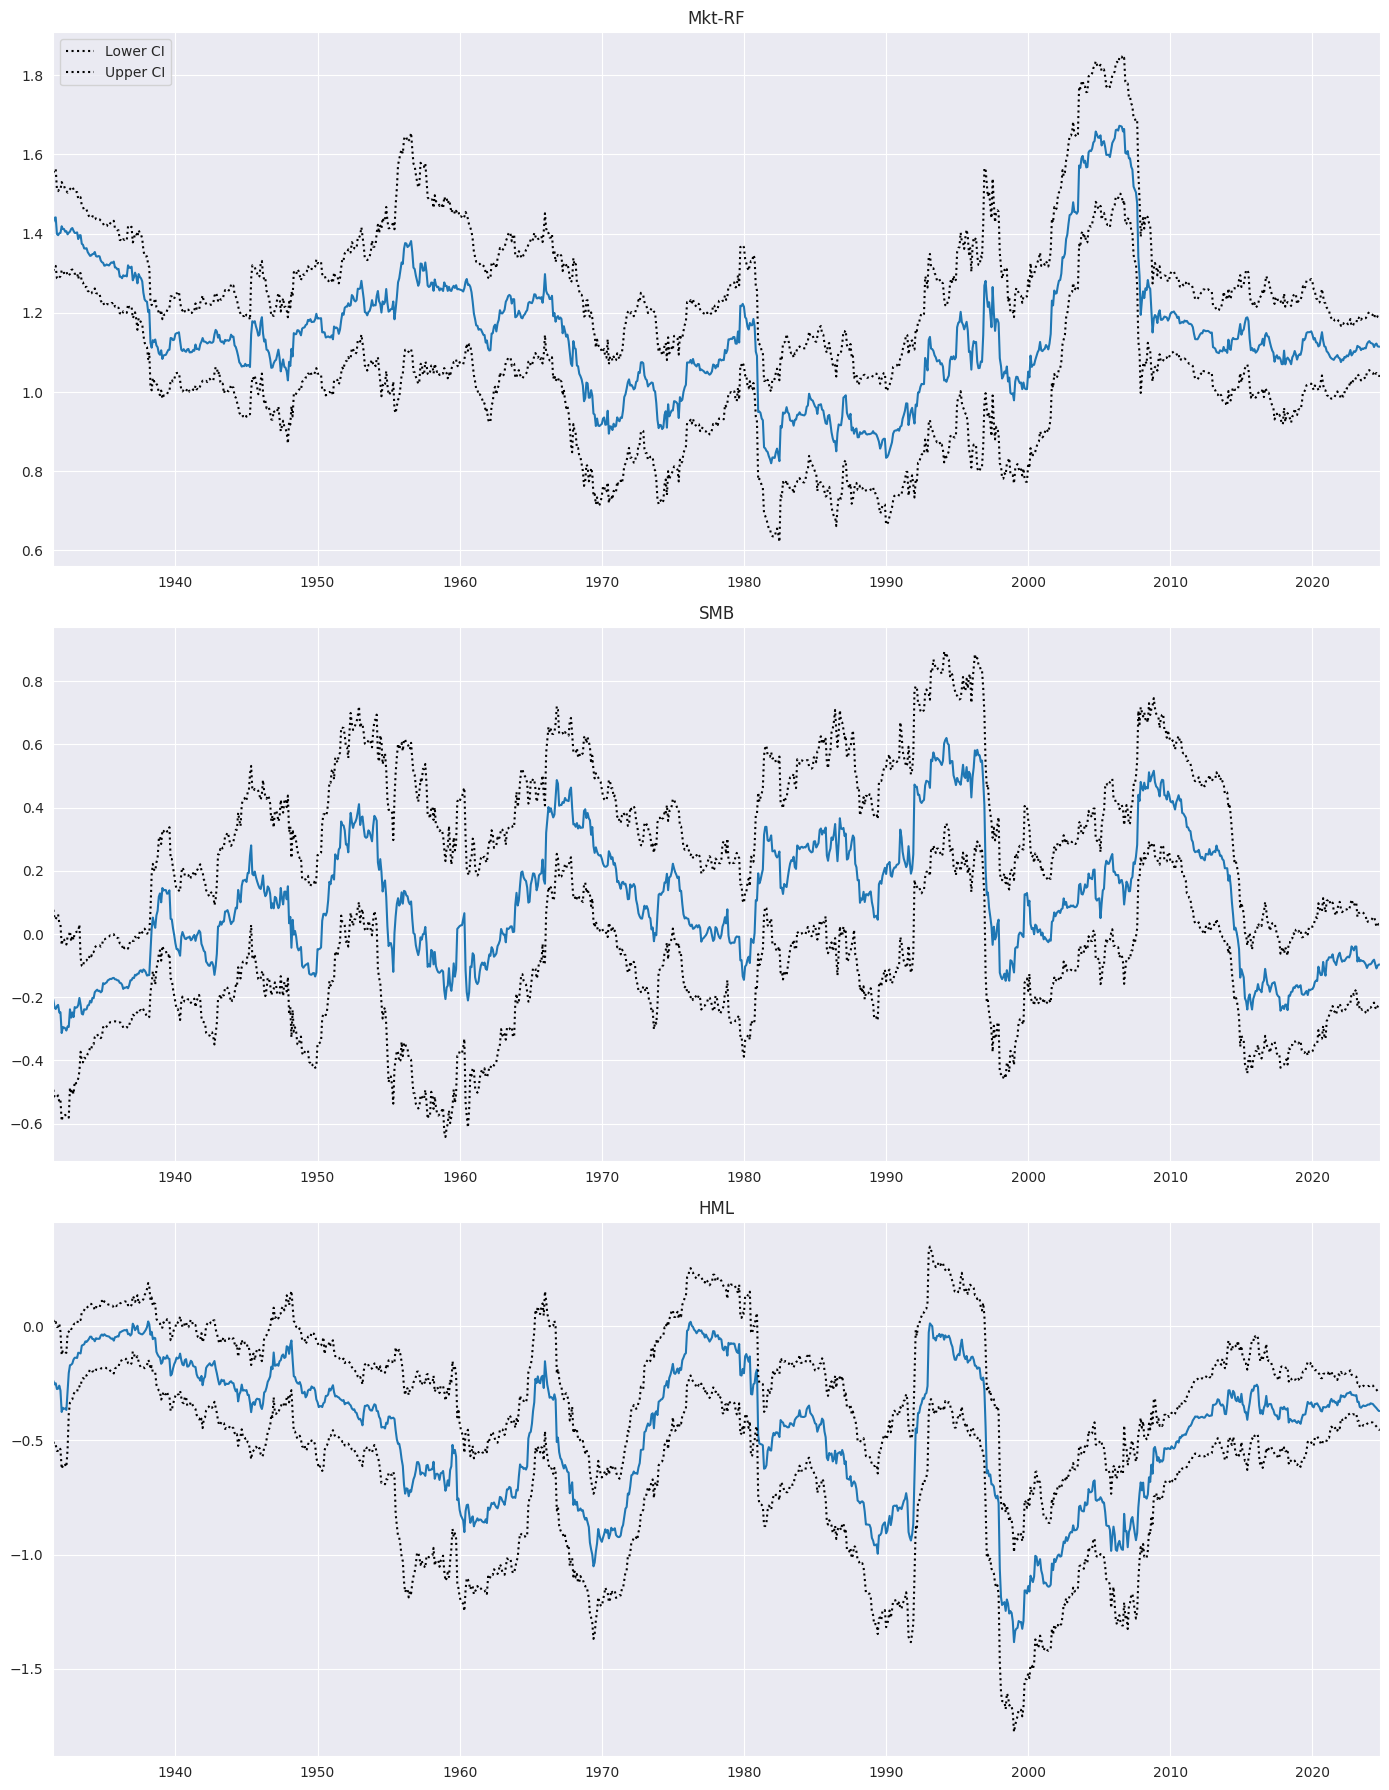

In [8]:
exog_vars = ["Mkt-RF", "SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(14, 18))

## Formulas

`RollingOLS` and `RollingWLS` both support model specification using the formula interface. The example below is equivalent to the 3-factor model estimated previously. Note that one variable is renamed to have a valid Python variable name.

In [9]:
joined = pd.concat([factors, industries], axis=1)
joined["Mkt_RF"] = joined["Mkt-RF"]
mod = RollingOLS.from_formula("HiTec ~ Mkt_RF + SMB + HML", data=joined, window=60)
rres = mod.fit()
rres.params.tail()

,Intercept,Mkt_RF,SMB,HML
Date,,,,
2024-06,0.719737,1.121550,-0.106983,-0.357407
2024-07,0.674945,1.122944,-0.115224,-0.361809
2024-08,0.691462,1.116347,-0.108607,-0.368910
2024-09,0.658722,1.115480,-0.104979,-0.375144
2024-10,0.672379,1.115185,-0.105212,-0.375359


## `RollingWLS`: Rolling Weighted Least Squares 

The `rolling` module also provides `RollingWLS` which takes an optional `weights` input to perform rolling weighted least squares.  It produces results that match `WLS` when applied to rolling windows of data. 

## Fit Options

Fit accepts other optional keywords to set the covariance estimator.  Only two estimators are supported, `'nonrobust'` (the classic OLS estimator) and `'HC0'` which is White's heteroskedasticity robust estimator.

You can set `params_only=True` to only estimate the model parameters.  This is substantially faster than computing the full set of values required to perform inference. 

Finally, the parameter `reset` can be set to a positive integer to control estimation error in very long samples. `RollingOLS` avoids the full matrix product when rolling by only adding the most recent observation and removing the dropped observation as it rolls through the sample. Setting `reset` uses the full inner product every `reset` periods.  In most applications this parameter can be omitted. 

In [10]:
%timeit rols.fit()
%timeit rols.fit(params_only=True)

354 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


81.4 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Expanding Sample
It is possible to expand the sample until sufficient observations are available for the full window length.  In this example, we start once we have 12 observations available, and then increase the sample until we have 60 observations available. The first non-`nan` value is computed using 12 observations, the second 13, and so on. All other estimates are computed using 60 observations.

In [11]:
res = RollingOLS(endog, exog, window=60, min_nobs=12, expanding=True).fit()
res.params.iloc[10:15]

,const,Mkt-RF,SMB,HML
Date,,,,
1927-05,NaN,NaN,NaN,NaN
1927-06,1.560283,0.999383,1.351219,-0.471879
1927-07,1.235899,1.294857,0.742924,-0.540048
1927-08,1.249999,1.297546,0.752327,-0.548306
1927-09,1.375626,1.286724,1.177758,-0.609331


In [12]:
res.nobs[10:15]

Date
1927-05     0
1927-06    12
1927-07    13
1927-08    14
1927-09    15
Freq: M, dtype: int64